# Ejercicio de programación Regresión Polinomial

In [470]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [471]:
# Repositorio de GitHub
# https://github.com/DiegoSolorzano9/Inteligencia_Artificial_I/tree/719f32dd9cbbe062105b8c91b89a853445d12804/Laboratorios/Lab%202

# utilizado para manejos de directorios y rutas
import os

# Computacion vectorial y cientifica para python
import numpy as np

# Librerias para graficación (trazado de gráficos)
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D  # Necesario para graficar superficies 3D

# llama a matplotlib a embeber graficas dentro de los cuadernillos
%matplotlib inline

## 2 Regresión polinomica

Se implementa la regresion polinomial para predecir el la capacidad adquisitiva de una persona. El archivo `Datasets/capacidad_adquisitiva.csv` contiene un dataset para entrenamiento de capacidad adquisitiva de las personas considerando la edad de las personas de la ciudad de Sucre. La primera columna es la edad y la segunda columna es la capacidad adquisitiva en bolivianos por mes.

<a id="section4"></a>
### 2.1 Normalización de caracteristicas

Al visualizar los datos se puede observar que las caracteristicas tienen diferentes magnitudes, por lo cual se debe transformar cada valor en una escala de valores similares, esto con el fin de que el descenso por el gradiente pueda converger mas rapidamente.

In [472]:
import pandas as pd

# Cargar el archivo CSV usando comas como delimitador
data = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Laboratorios/Lab 2/fifa_players.csv', delimiter=",")

# Seleccionar las columnas 'age' y 'value_euro' para el análisis
X = pd.to_numeric(data['age'], errors='coerce')
y = pd.to_numeric(data['value_euro'], errors='coerce')

# Filtrar filas con valores NaN
valid_rows = ~pd.isnull(X) & ~pd.isnull(y)
X = X[valid_rows]
y = y[valid_rows]

m = y.size

# Imprimir algunos puntos de datos
for i in range(20):
    print('{:8.0f}{:10.0f}'.format(X[i], y[i]))

      31 110500000
      27  69500000
      25  73000000
      27  62000000
      27  60000000
      27  59500000
      20  81000000
      30  64500000
      32  38000000
      32  60000000
      30  51500000
      26  53500000
      26  58000000
      27  78000000
      26  78500000
      25  89000000
      24  53500000
      33  20500000
      31  48500000
      30  46500000


La desviación estándar es una forma de medir cuánta variación hay en el rango de valores de una característica en particular (la mayoría de los puntos caeran en un rango de ± 2 en relación a la desviaciones estándar de la media); esta es una alternativa a tomar el rango de valores (max-min). En `numpy`, se puede usar la función `std` para calcular la desviacion estandar.

Por ejemplo, la caracteristica`X[:, 0]` contiene todos los valores de $x_1$ (edades) en el conjunto de entrenamiento, entonces `np.std(X[:, 0])` calcula la desviacion estandar de las edades.
En el momento en que se llama a la función `featureNormalize`, la columna adicional de unos correspondiente a $ x_0 = 1 $ aún no se ha agregado a $ X $.

<div class="alert alert-block alert-warning">
**Notas para la implementación:** Cuando se normalize una caracteristica, es importante almacenar los valores usados para la normalización - el valor de la media y el valor de la desviación estandar usado para los calculos. Despues de aprender los parametros del modelo, se deseara predecir la capacidad adquisitiva que no se han visto antes. Dado un nuevo valor de x (edad), primero se debe normalizar x usando la media y la desviacion estandar que se empleo anteriormente en el conjunto de entrenamiento para entrenar el modelo.
</div>
<a id="featureNormalize"></a>

In [473]:
def plotData(x, y):
    #Grafica los puntos x e y en una figura nueva.

    fig = pyplot.figure()  # abre una nueva figura

    pyplot.plot(x, y, 'ro', ms=10, mec='k')
    pyplot.grid(True)
    pyplot.title('Sueldo vs Edad de los Futbolistas')
    pyplot.ylabel('Sueldo en Euros')
    pyplot.xlabel('Edad de los Futbolistas')

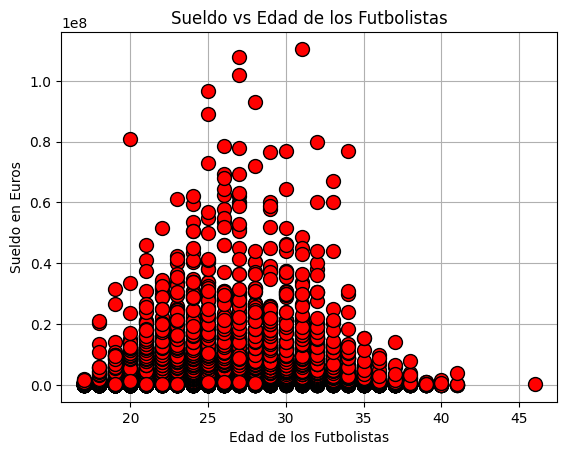

In [426]:
plotData(X, y)

In [474]:
# X = np.concatenate([X, X * X], axis=1)

X = np.array(X).reshape(-1, 1)
X_squared = X * X
X = np.concatenate([X, X_squared], axis=1)

In [475]:
print(X)

[[ 31 961]
 [ 27 729]
 [ 25 625]
 ...
 [ 22 484]
 [ 21 441]
 [ 19 361]]


In [476]:
def featureNormalize(X):
    # Asegurarse de que X sea 2D
    if X.ndim == 1:
        X = X.reshape(-1, 1)

    X_norm = X.copy()
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0)

    # Evitar división por cero si sigma es cero
    sigma[sigma == 0] = 1

    X_norm = (X - mu) / sigma

    return X_norm, mu, sigma

In [477]:
# llama featureNormalize con los datos cargados
X_norm, mu, sigma = featureNormalize(X)

#print(X)
#print('Media calculada:', mu)
#print('Desviación estandar calculada:', sigma)
#print(X_norm)

Despues de `featureNormalize` la funcion es provada, se añade el temino de interseccion a `X_norm`:

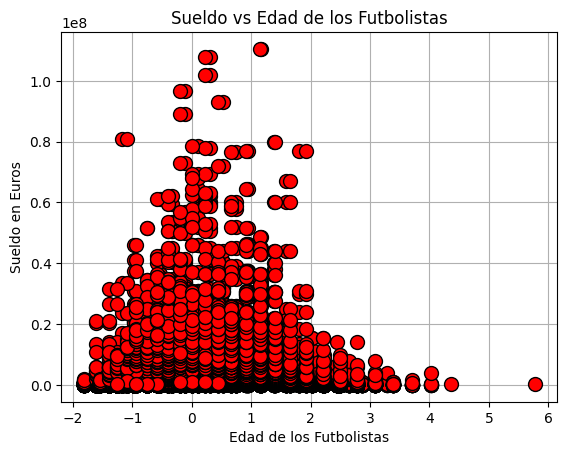

In [478]:
plotData(X_norm, y)

In [479]:
# Añade el termino de interseccion a X
# (Columna de unos para X0)
#X_norm = np.concatenate([X_norm, X_norm * X_norm], axis=1)
X = np.concatenate([np.ones((m, 1)), X_norm], axis=1)

In [480]:
print(X)

[[ 1.          1.16386136  1.14886341]
 [ 1.          0.31222439  0.22009562]
 [ 1.         -0.1135941  -0.19624857]
 ...
 [ 1.         -0.75232183 -0.7607152 ]
 [ 1.         -0.96523107 -0.93285751]
 [ 1.         -1.39104956 -1.25312226]]


<a id="section5"></a>
### 2.2 Descenso por el gradiente

En el ejemplo anterior se implemento el descenso por el gradiente para un problema de regresion univariable. La unica diferencia es que ahora existe una caracteristica adicional en la matriz $X$. La función de hipótesis y la regla de actualización del descenso del gradiente por lotes permanecen sin cambios.

La implementacion de las funciones `computeCostMulti` y `gradientDescentMulti` son similares a la funcion de costo y función de descenso por el gradiente de la regresión lineal multiple es similar al de la regresion lineal multivariable. Es importante garantizar que el codigo soporte cualquier numero de caracteristicas y esten bien vectorizadas.

Se puede utilizar `shape`, propiedad de los arrays `numpy`, para identificar cuantas caracteristicas estan consideradas en el dataset.

<div class="alert alert-block alert-warning">
**Nota de implementación:** En el caso de multivariables, la función de costo puede se escrita considerando la forma vectorizada de la siguiente manera:

$$ J(\theta) = \frac{1}{2m}(X\theta - \vec{y})^T(X\theta - \vec{y}) $$

donde:

$$ X = \begin{pmatrix}
- (x^{(1)})^T - \\
- (x^{(2)})^T - \\
\vdots \\
- (x^{(m)})^T - \\ \\
\end{pmatrix} \qquad \mathbf{y} = \begin{bmatrix} y^{(1)} \\ y^{(2)} \\ \vdots \\ y^{(m)} \\\end{bmatrix}$$

La version vectorizada es eficiente cuando se trabaja con herramientas de calculo numericos computacional como `numpy`.
</div>

<a id="computeCostMulti"></a>

In [481]:
def computeCostMulti(X, y, theta):
    # Inicializa algunos valores utiles
    m = y.shape[0] # numero de ejemplos de entrenamiento

    J = 0

    h = np.dot(X, theta)

    J = (1/(2 * m)) * np.sum(np.square(np.dot(X, theta) - y))

    return J


In [482]:
def gradientDescentMulti(X, y, theta, alpha, num_iters):

    # Inicializa algunos valores
    m = y.shape[0] # numero de ejemplos de entrenamiento

    # realiza una copia de theta, el cual será acutalizada por el descenso por el gradiente
    theta = theta.copy()

    J_history = []

    for i in range(num_iters):
        theta = theta - (alpha / m) * (np.dot(X, theta) - y).dot(X)
        J_history.append(computeCostMulti(X, y, theta))

    return theta, J_history

#### 3.2.1 Seleccionando coheficientes de aprendizaje


theta calculado por el descenso por el gradiente: [ 2479280.1853212   8815814.21207229 -8391317.19674966]
La capacidad adquisitiva para una persona de 33 (usando el descenso por el gradiente): $2179451


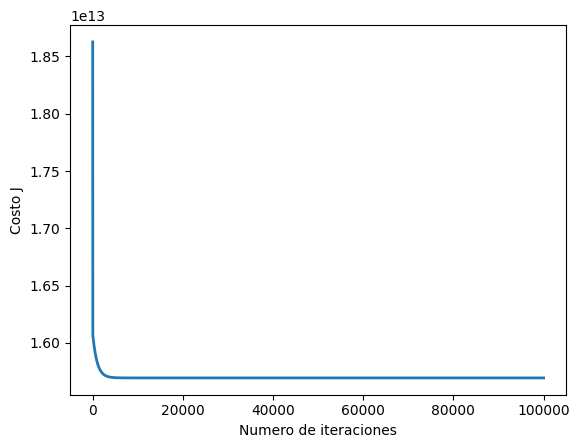

In [483]:
# Elegir algun valor para alpha (probar varias alternativas)
alpha = 0.1
num_iters = 100000

# inicializa theta y ejecuta el descenso por el gradiente
theta = np.zeros(3)
theta, J_history = gradientDescentMulti(X, y, theta, alpha, num_iters)

# Grafica la convergencia del costo
pyplot.plot(np.arange(len(J_history)), J_history, lw=2)
pyplot.xlabel('Numero de iteraciones')
pyplot.ylabel('Costo J')

# Muestra los resultados del descenso por el gradiente
print('theta calculado por el descenso por el gradiente: {:s}'.format(str(theta)))

# La capacidad adquisitiva de una persona de 33 años
X_array = [1, 34, 1156]
X_array[1:3] = (X_array[1:3] - mu) / sigma
price = np.dot(X_array, theta)   # Se debe cambiar esto

print('La capacidad adquisitiva para una persona de 33 (usando el descenso por el gradiente): ${:.0f}'.format(price))

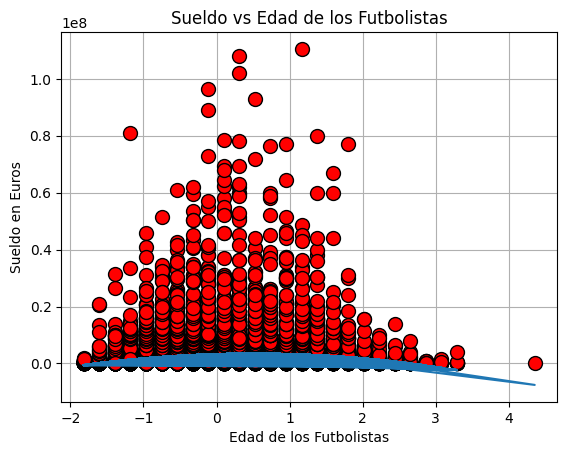

In [484]:
plotData(X[:, 1], y)
pyplot.plot(X[:, 1], np.dot(X, theta), '-')

In [485]:
# Generar valores de entrada (edades) para las predicciones
ages = np.linspace(19, 40, 100)  # Generar 100 edades entre 18 y 40 años

# Crear un array para las características X
X_pred = np.array(ages).reshape(-1, 1)
X_pred_squared = X_pred * X_pred
X_pred = np.concatenate([X_pred, X_pred_squared], axis=1)

# Normalizar las características para las predicciones
X_pred_norm, _, _ = featureNormalize(X_pred)

# Añadir columna de unos (término de sesgo)
X_pred_norm = np.concatenate([np.ones((X_pred_norm.shape[0], 1)), X_pred_norm], axis=1)

# Realizar predicciones
predictions = np.dot(X_pred_norm, theta)

# Mostrar algunas de las predicciones en millones de euros
for age, pred in zip(ages, predictions):
    pred_millions = pred / 1e6  # Convertir el valor a millones de euros
    print(f'El futbolista con edad de: {age:.0f} años, su valor predicho es: €{pred_millions:.2f} millones')

El futbolista con edad de: 19 años, su valor predicho es: €0.01 millones
El futbolista con edad de: 19 años, su valor predicho es: €0.12 millones
El futbolista con edad de: 19 años, su valor predicho es: €0.24 millones
El futbolista con edad de: 20 años, su valor predicho es: €0.35 millones
El futbolista con edad de: 20 años, su valor predicho es: €0.47 millones
El futbolista con edad de: 20 años, su valor predicho es: €0.58 millones
El futbolista con edad de: 20 años, su valor predicho es: €0.68 millones
El futbolista con edad de: 20 años, su valor predicho es: €0.79 millones
El futbolista con edad de: 21 años, su valor predicho es: €0.89 millones
El futbolista con edad de: 21 años, su valor predicho es: €0.99 millones
El futbolista con edad de: 21 años, su valor predicho es: €1.09 millones
El futbolista con edad de: 21 años, su valor predicho es: €1.19 millones
El futbolista con edad de: 22 años, su valor predicho es: €1.28 millones
El futbolista con edad de: 22 años, su valor predic

<a id="section7"></a>
### 2.3 Ecuacion de la Normal

Una manera de calcular rapidamente el modelo de una regresion lineal es:

$$ \theta = \left( X^T X\right)^{-1} X^T\vec{y}$$

Utilizando esta formula no requiere que se escale ninguna caracteristica, y se obtendra una solucion exacta con un solo calculo: no hay “bucles de convergencia” como en el descenso por el gradiente.

Primero se recargan los datos para garantizar que las variables no esten modificadas. Recordar que no es necesario escalar las caracteristicas, se debe agregar la columna de unos a la matriz $X$ para tener el termino de intersección($\theta_0$).

In [486]:
# Cargar datos
data = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Laboratorios/Lab 2/fifa_players.csv', delimiter=",")

# Seleccionar las columnas 'age' y 'value_euro' para el análisis
X = pd.to_numeric(data['age'], errors='coerce')
y = pd.to_numeric(data['value_euro'], errors='coerce')

# Filtrar filas con valores NaN
valid_rows = ~pd.isnull(X) & ~pd.isnull(y)
X = X[valid_rows]
y = y[valid_rows]

m = y.size

X_original = X.copy()
# X = np.concatenate([X, X * X], axis=1)

# Convertir X a una matriz bidimensional
X = np.array(X).reshape(-1, 1)  # Convertir X a un array numpy y luego cambiar la forma a (n, 1)

# Concatenar X con X^2
X_squared = X * X
X = np.concatenate([X, X_squared], axis=1)

X = np.concatenate([np.ones((m, 1)), X], axis=1)

In [487]:
def normalEqn(X, y):

    theta = np.zeros(X.shape[1])

    theta = np.dot(np.dot(np.linalg.inv(np.dot(X.T,X)),X.T),y)

    return theta

In [488]:
# Calcula los parámetros con la ecuación de la normal
theta = normalEqn(X, y)

# Muestra los resultados obtenidos a partir de la aplicación de la ecuación de la normal
print('Theta calculado a partir de la ecuación de la normal: {}'.format(theta))

# Generar 100 edades en un rango
ages = np.linspace(19, 40, 100)  # Rango de edades de 19 a 40
X_new = np.array(ages).reshape(-1, 1)

# Crear las características cuadráticas
X_new_squared = X_new * X_new
X_new = np.concatenate([X_new, X_new_squared], axis=1)

# Añadir la columna de unos para el término de sesgo
X_new = np.concatenate([np.ones((X_new.shape[0], 1)), X_new], axis=1)

# Realizar las predicciones
predictions = np.dot(X_new, theta)

# Convertir las predicciones a millones de euros
predictions_millions = predictions / 1e6

# Imprimir las predicciones
for age, price in zip(ages, predictions_millions):
    print(f'El futbolista con edad de: {age:.0f} años, tiene un valor predicho de: €{price:.2f} millones')


Theta calculado a partir de la ecuación de la normal: [-22803918.92792654   1876968.33210581    -33593.03951204]
El futbolista con edad de: 19 años, tiene un valor predicho de: €0.73 millones
El futbolista con edad de: 19 años, tiene un valor predicho de: €0.86 millones
El futbolista con edad de: 19 años, tiene un valor predicho de: €0.98 millones
El futbolista con edad de: 20 años, tiene un valor predicho de: €1.10 millones
El futbolista con edad de: 20 años, tiene un valor predicho de: €1.22 millones
El futbolista con edad de: 20 años, tiene un valor predicho de: €1.33 millones
El futbolista con edad de: 20 años, tiene un valor predicho de: €1.44 millones
El futbolista con edad de: 20 años, tiene un valor predicho de: €1.55 millones
El futbolista con edad de: 21 años, tiene un valor predicho de: €1.65 millones
El futbolista con edad de: 21 años, tiene un valor predicho de: €1.76 millones
El futbolista con edad de: 21 años, tiene un valor predicho de: €1.85 millones
El futbolista con 

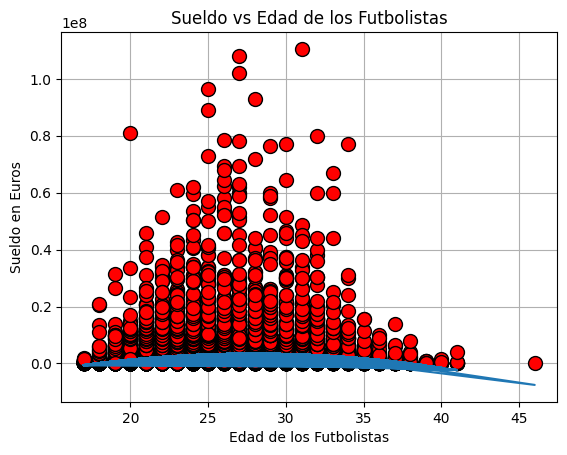

In [489]:
plotData(X[:, 1], y)
#X = np.concatenate([np.ones((m, 1)), X], axis=1)
#X = np.concatenate([X, X * X], axis=1)

pyplot.plot(X[:, 1], np.dot(X, theta), '-')